  ## Introduction
  
In this paper I introduce a method to train neural networks on only part of their training data.
First I introduce a method I like to call splitting the difference. It might be kind of the same as something in another paper, but papers, like code, are easier to write than to read. (At least that one is), so its hard to tell.
Either way, The other paper didn't explain the  method very well.
Suppose you have a neural network. You have a pair of input images, and wish to explain why it made the difference decisions it made. The following method tracks differences back through the network. By gradient descenting on these differences, it is possible to teach the network about arbitrary subsets of its training data, without teaching it about the rest. 


This section imports some stuff. It loads the data for the network to be tested on. It also defines a function that normalizes the image, and surrounds it 

In [43]:
#This module trains a small neural network to determine if a point is inside or outside a circle, and then saves that model to a file.

#First import some libraries.
import tensorflow as tf
import numpy as np
from math import *
import matplotlib.pyplot as plt
import matplotlib as mpl 
mpl.rcParams["savefig.directory"] = ""
import copy
from itertools import *

import tensorflow.keras.layers as la
import tensorflow_datasets as tfds
train, test = tf.keras.datasets.mnist.load_data()

images, labels = train
images = images/255.0
labels = labels.astype(np.int32)

data = tf.data.Dataset.from_tensor_slices((images, labels))


In [12]:
GRADIENT={}#"lambda":"gradient","bias":"gradient","linear":"gradient"}
#EPSILON=0.001# This doesn't fit into my nice propegation scheme, so its a global constant.



def get_shape(x):
    return x.shape.as_list()
def replace_none(l,v):
    return [v if i is None else i for i in l]
def short_str(x):
    if x is None:
        return "None"
    try: 
        return str(type(x))+str(get_shape(x))+str(x.dtype)+str(np.any(tf.math.is_nan(x).numpy()))
    except:
        return str(type(x))

def get_gradient(f):
    def g(x,y,dy):
        #print(x,dy)
        with tf.GradientTape() as tape:
            #if f linear then this doesn't depend on x.
            tape.watch(x)
            z=f(x)*dy
        return tape.gradient(z,x)
        
    return g



The *Level* represents a tensor of values (representing 2 images) in the feedforward network, and also holds a tensor representing a single value on the backstroke.



In [13]:
OFFST=1
#convention, baseline compares 2 items. So the 0'th is the baseline, the rest are compared to it.


class LevelWrapper:
    def __init__(self, shape):
        self._=None
        self.R=None
        self.shape=shape
    def __repr__(self):
        return "_=%s,  R=%s;%s"%(short_str(self._),short_str(self.R),np.sum((self._.numpy()[OFFST:]-self._.numpy()[:1])*self.R.numpy()))
class LayerWrapper:
    name="layer"
    def __init__(self, a,b):
    
        self.a=a
        self.b=b
        

    def fwd(self):
        self.b._=self.func(self.a._)
    def bkw(self, choice):

        if isinstance(choice, dict):
            
            name=choice.get(self.name,"gradient")
        else:
            if hasattr(self,choice):
                name=choice
            else:
                name="gradient"
        rev_func=getattr(self,name)
        assert self.b.R is not None
        assert self.a._ is not None
        assert self.b._ is not None
        if not (isinstance(self,MaxWrapper)  or isinstance(self,SoftmaxWrapper)or isinstance(self,LogmaxWrapper) or isinstance(self, BiasWrapper) or isinstance(self,LambdaWrapper) or isinstance(self,LinearWrapper)):
            self.a.R=rev_func(self.a._[OFFST:],self.b._[OFFST:],self.b.R)
        else:
            self.a.R=rev_func(self.a._,self.b._,self.b.R)
        assert self.a.R is not None
    def gradient(self,x,y,dy):
        if hasattr(self,"func"):
            return get_gradient(self.func)(x,y,dy)
        raise NotImplemented()

The lambda wrapper wraps an arbitrary function.

Let $x_1[i]$ and $x_2[i]$ be the i'th component derived from input images 1 and 2. And $y_1[i]$, $y_2[i]$ corresponding outputs.

Then 
$$R_x[i]=\frac{y_2[i]-y_1[i]}{x_2[i]-x_1[i]}R_y[i]$$

In [14]:
class LambdaWrapper(LayerWrapper):
    name="lambda"
    def __init__(self,a,b,func,gradient=None):
        if isinstance(func,la.Activation):
            func=func.activation
        assert func.__name__!="softmax" if hasattr(func,"__name__") else True, "This function isn't elementwise"
        LayerWrapper.__init__(self,a,b)
        self.func=func
        self.func0=func(tf.zeros([]))
        self.gradient=gradient
        if self.gradient is None:
            self.gradient=get_gradient(self.func)
#    def slope(self,x,y,dy):
#        return tf.math.divide_no_nan(dy*y,x)
#    def ignore(self,x,y,dy):
#        return dy
#    def repeat(self,x,y,dy):
#        return self.func(dy)
#    def blame(self,x,y,dy):
#        return dy*(y-self.func0)/x
    def compare(self,x,y,dy):
        return tf.math.divide_no_nan(dy*(y[1:]-y[:1]),(x[1:]-x[:1]))

The bias is just a trivial special case of the lambda. When $y_1[i]=x_1[i]+c$ then 
$$\frac{y_2[i]-y_1[i]}{x_2[i]-x_1[i]}=1$$
So
$$R_x[i]=R_y[i]$$

In [15]:
class BiasWrapper(LayerWrapper):
    name="bias"
    def __init__(self,a,b,bias):
        LayerWrapper.__init__(self,a,b)
        self.bias=bias
    def func(self,x):
        return x+self.bias
#    def gradient(self, x,y,dy):
#        assert get_shape(y)==get_shape(dy)
#        return dy
    def compare(self, x,y,dy):
        assert get_shape(y)[0]==get_shape(dy)[0]+1
        return dy

Some of these are fairly trivial. Max isn't used in this particular network. Reshape trivially applies the reverse reshape when flowing backwards.

In [16]:

class MaxWrapper(LayerWrapper):
    name="max"
    def __init__(self,a,b,func):
        LayerWrapper.__init__(self,a,b)
        self.func=func
        #self.gradient=get_gradient(self.func)
    def compare(self,x,y,dy):
        X,x=x[:1],x[1:]
        Y,y=y[:1],y[1:]
        def rev(zz):
            return get_gradient(self.func)(x,y,zz)
        inm=tf.where(y>Y,y-Y,0)*dy
        kk=rev(inm)/(x-X)
        return tf.where(tf.math.is_nan(kk), 0, kk)#not 0?
        
        #return (y-Y)/(x-X)*((x==y)*(y>Y)+(X==Y)*(Y>y))*dy
        raise NotImplementedError
        #(m-M)/(x-X)*((x==m)*(m>M)+(X==M)*(M>m))
    
class ReshapeWrapper(LayerWrapper):
    name="reshape"
    def __init__(self,a,b,func):
        LayerWrapper.__init__(self,a,b)
        self.func=func
        self.gradient=lambda x,y,dy:tf.reshape(dy,replace_none(a.shape,get_shape(y)[0]),"reshapor")
class SoftmaxWrapper(LayerWrapper):
    name="softmax"
    def __init__(self,a,b):
        LayerWrapper.__init__(self,a,b)
        self.func=tf.keras.activations.softmax
    def compare(self,x,y,dy):
        assert get_shape(y)[0]==get_shape(dy)[0]+1
        X,x=x[:1],x[1:]
        Y,y=y[:1],y[1:]
        E,e=tf.reduce_logsumexp(X,1,keepdims=True),tf.reduce_logsumexp(x,1,keepdims=True)
        q=tf.maximum(E,e)
        w=tf.minimum(E,e)-q
        
        intr=(w/tf.math.expm1(w))*((tf.exp(x-q)-tf.exp(X-q))/(x-X))
        intr2=(e-E)/(x-X)*(tf.exp(x)-tf.exp(X))/(tf.exp(e)-tf.exp(E))
        #print("small",np.absolute((intr-intr2).numpy()).max())
        k=dy*((y-Y)/(x-X-e+E))
        qqq=k-intr*tf.reduce_sum(k,1,keepdims=True)
        #print("similar",tf.reduce_sum((y-Y)*dy,1),tf.reduce_sum(qqq*(x-X),1))
        #dy2=dy*(y-Y)/(tf.math.log(y)-tf.math.log(Y))
        #dys=tf.reduce_sum(dy2,1,keepdims=True)
        #c=tf.exp(x),tf.exp(X)
        #d=tf.reduce_sum(c[0],1,keepdims=True),tf.reduce_sum(c[1],1,keepdims=True)
        #ee=tf.math.log(d[0]),tf.math.log(d[1])
        #qqk=dy2-dys*(ee[0]-ee[1])/(d[0]-d[1])*(c[0]-c[1])/(x-X)
        #qqk=qqq
        #qqk is the more mathematically simple, but less accurate version/
        #assert 0
        return qqq
    
class LogmaxWrapper(LayerWrapper):
    name="softmax"
    def __init__(self,a,b):
        LayerWrapper.__init__(self,a,b)
    def func(self,x):
        
        m=tf.reduce_logsumexp(x,1,keepdims=True)
        return x-m
    def compare(self,x,y,dy):
        assert get_shape(y)[0]==get_shape(dy)[0]+1
        X,x=x[:1],x[1:]
        Y,y=y[:1],y[1:]
        E,e=tf.reduce_logsumexp(X,1,keepdims=True),tf.reduce_logsumexp(x,1,keepdims=True)
        q=tf.maximum(E,e)
        w=tf.minimum(E,e)-q
        
        intr=(w/tf.math.expm1(w))*((tf.exp(x-q)-tf.exp(X-q))/(x-X))
        intr2=(e-E)/(x-X)*(tf.exp(x)-tf.exp(X))/(tf.exp(e)-tf.exp(E))
        #print("small",np.absolute((intr-intr2).numpy()).max())
        k=dy#*((y-Y)/(x-X-e+E))
        qqq=k-intr*tf.reduce_sum(k,1,keepdims=True)
        #print("similar",tf.reduce_sum((y-Y)*dy,1),tf.reduce_sum(qqq*(x-X),1))
        #dy2=dy*(y-Y)/(tf.math.log(y)-tf.math.log(Y))
        #dys=tf.reduce_sum(dy2,1,keepdims=True)
        #c=tf.exp(x),tf.exp(X)
        #d=tf.reduce_sum(c[0],1,keepdims=True),tf.reduce_sum(c[1],1,keepdims=True)
        #ee=tf.math.log(d[0]),tf.math.log(d[1])
        #qqk=dy2-dys*(ee[0]-ee[1])/(d[0]-d[1])*(c[0]-c[1])/(x-X)
        #qqk=qqq
        #qqk is the more mathematically simple, but less accurate version/
        #assert 0
        return qqq
        
        
class LinearWrapper(LayerWrapper):
    name="linear"
    def __init__(self,a,b,func):
        LayerWrapper.__init__(self,a,b)
        self.func=func
    def normalized(self,x,y,dy):
        return x*self.gradient(x,"placeholder variable",dy/blip(y))
    def compare(self,x,y,dy):
        return self.gradient(x[1:],"placeholder variable",dy)

In [44]:




class Stack():
    def __init__(self,layers):
        self.Levels=[LevelWrapper(get_shape(layers[0].input))]
        self.Layers=[]
        for l1,l2 in zip(layers,layers[1:]):
            #assert l1.output.ref()==l2.input.ref(), "abnormality detected. Layers should be sequential."
            pass
        for layer in layers:
            self.push_layer(layer)
    def __repr__(self):
        return "\n".join(l.__repr__() for l in self.Levels)
    def push(self,layer,out_size,*args):
        self.Levels.append(LevelWrapper(out_size))
        self.Layers.append(layer(self.Levels[-2],self.Levels[-1],*args))
    def push_layer(self,layer):
        out_shape=get_shape(layer.output)
        if isinstance(layer,tf.keras.layers.Lambda) or isinstance(layer,tf.keras.layers.Activation):
            
            if isinstance(layer,tf.keras.layers.Activation) and layer.activation.__name__=="softmax":
                self.push(SoftmaxWrapper,out_shape)
            else:
                print(layer, " assumed to be elementwise")
                self.push(LambdaWrapper,out_shape,layer)
        elif any(isinstance(layer,i) for i in [la.Average,
                                               la.AveragePooling1D,la.AveragePooling2D,la.AveragePooling3D,la.Conv1D,la.Conv2D,la.Conv3D,la.Dense]):
            layer=copy.copy(layer)
            if hasattr(layer,"activation"):
                print(layer, layer.activation.__name__," assumed to be linear + Maybe(bias) + Maybe(elementwise activation)")

                activation=layer.activation
                layer.activation=tf.keras.activations.linear
            bias=None
            if hasattr(layer,"bias"):
                bias=layer.bias
                assert (bias is not None) == layer.use_bias
                layer.use_bias=False
            self.push(LinearWrapper,out_shape,layer)
            if bias is not None:
                self.push(BiasWrapper,out_shape,bias)
            
            if hasattr(layer,"activation"):
                if activation.__name__ not in ("linear","softmax"):
                    self.push(LambdaWrapper,out_shape,activation)
                elif activation.__name__ =="softmax":
                    self.push(SoftmaxWrapper,out_shape)
        elif any(isinstance(layer,i) for i in[la.Maximum,la.MaxPool1D,la.MaxPool2D,
                                              la.MaxPool3D,la.MaxPooling1D,la.MaxPooling2D,la.MaxPooling3D]):
            print(layer, " assumed to be max")
            self.push(MaxWrapper,out_shape,layer)

        elif any(isinstance(layer,i) for i in[la.Reshape,la.Flatten]):
            print(layer, " assumed to be reshaper")
            self.push(ReshapeWrapper,out_shape,layer)
        else:
            
            print(layer, "layer can't be parsed as a linear function or an activation function, so it was ignored.")
            assert layer.input.shape==layer.output.shape
        





#load model from file.
model=tf.keras.models.load_model("/home/donald/Desktop/PhD_project/Foo/LW2/simple_model1")










s=Stack(model.layers)

def flow(stack,data,grad_init):
    stack.Levels[0]._=tf.constant(data)
    for i in stack.Layers:
        i.fwd()
    
    stack.Levels[-1].R=grad_init(stack.Levels[-1]._)
    
    for i in stack.Layers[::-1]:
        i.bkw("compare")
    return stack.Levels[0].R



out_hoped=np.identity(10,np.float32)
d=data.as_numpy_iterator()







<keras.layers.core.Reshape object at 0x7fbe8daae490>  assumed to be reshaper
<keras.layers.convolutional.Conv2D object at 0x7fbeea33f4f0> relu  assumed to be linear + Maybe(bias) + Maybe(elementwise activation)
<keras.layers.convolutional.Conv2D object at 0x7fbeea2a6880> relu  assumed to be linear + Maybe(bias) + Maybe(elementwise activation)
<keras.layers.core.Flatten object at 0x7fbe8ad09160>  assumed to be reshaper
<keras.layers.core.Dense object at 0x7fbeea2dddf0> relu  assumed to be linear + Maybe(bias) + Maybe(elementwise activation)
<keras.layers.core.Dense object at 0x7fbeea329670> relu  assumed to be linear + Maybe(bias) + Maybe(elementwise activation)
<keras.layers.core.Dense object at 0x7fbeea2afb20> linear  assumed to be linear + Maybe(bias) + Maybe(elementwise activation)


In [57]:
next(d)
val=-1
while val!=3:
    pic,val =next(d)
    
tot=0
while True: 
    try:
        while val2!=8:
            pic2,val2 =next(d)
        out_hoped=np.zeros([1,10],np.float32)
        out_hoped[0,val]=1
        #k=np.stack(k,0)
        #np.zeros([28,28],np.float32)
        data_=np.stack([pic2,pic],axis=0)
        print("Image supposed to be a ",val,val2)
        #out_hoped=np.zeros([1,5],np.float32)
        #out_hoped[:,i]=1
        mxk=24
        for i in s.Levels:
            i._=None
            i.R=None
        q=flow(s,data_,lambda x:tf.constant(out_hoped))
        tot+=q
    except StopIteration:
        break

plt.imshow(pic)
plt.show()
plt.imshow(pic2)
plt.show()
plt.imshow(tot.numpy()[0,:])
plt.show()
#plt.plot(model(pic[None,:])[0],"kx")
#plt.show()
#plt.plot(s.Levels[-1]._[0],"kx")
#plt.show()

Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be

Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be

Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be

Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be

Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8
Image supposed to be a  3 8


KeyboardInterrupt: 

In [55]:
pic.max()

1.0

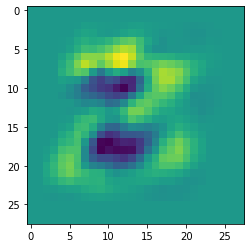

In [58]:
plt.imshow(tot.numpy()[0,:])

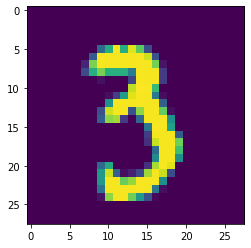

In [59]:
plt.imshow(pic)